## Assignment 2: Clustering with GMM

**Team: Psychic-Pandas**

&nbsp;
**Anjana Eldo (SJSU ID :012488983)**

&nbsp;
**Anjana Kamath Miyar (SJSU ID: 011526762)**

&nbsp;
**Mudrita Chaturvedi (SJSU ID: 012418094)**

&nbsp;
**Vidya Coimbatore Nand Kumar (SJSU ID: 010816832)**


In [9]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture


X = pd.read_csv('data.csv')

### Cleaning data 

In [10]:
demographic_attributes = ['Gender','Category']
X = X.drop(demographic_attributes, axis = 'columns')

X.head()

,Height,Weight
0,174,96
1,189,87
2,185,110
3,195,104
4,149,61


### Applying K-means vs GMM clustering

In [11]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [12]:
def plot_kmeans_stretched(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

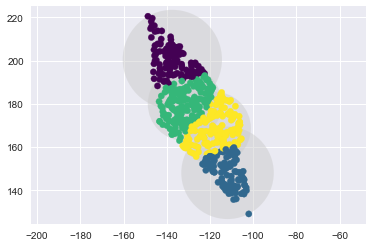

In [13]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans_stretched(kmeans, X_stretched)

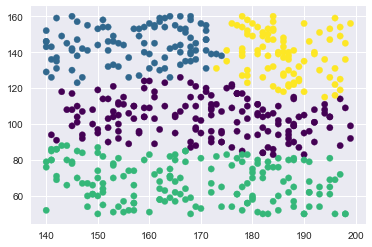

In [14]:

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis');

In [15]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.945 0.    0.052 0.003]
 [0.778 0.    0.218 0.004]
 [0.776 0.    0.001 0.223]
 [0.89  0.    0.003 0.107]
 [0.002 0.    0.998 0.   ]]


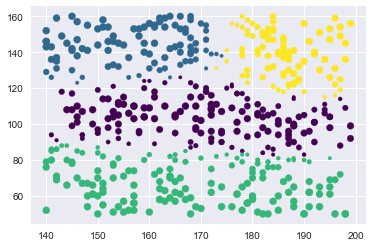

In [16]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', s=size);

### GMM Generator

In [17]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [18]:
def plot_gmm_stretched(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

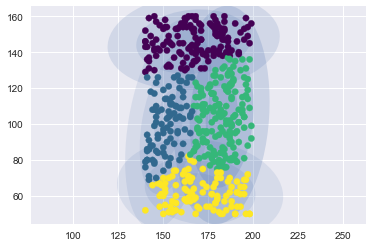

In [19]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

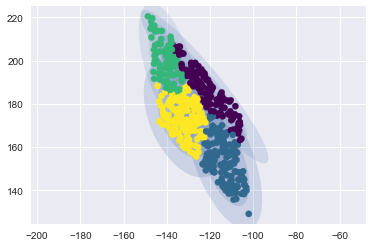

In [20]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm_stretched(gmm, X_stretched)

### Using AIC/BIC to identify optimal number of n components 

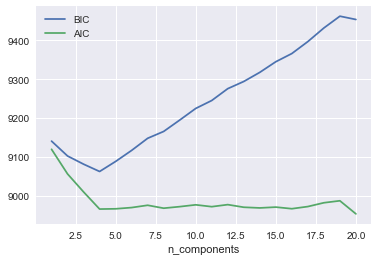

In [21]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### Comparison using silhouette score

In [24]:

from  sklearn.metrics import silhouette_score
n_clusters=n_components
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)
silhouette_avg = silhouette_score(X, labels,metric='euclidean')
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
silhouette_avg = silhouette_score(X, labels,metric='euclidean')
print("For n_components =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] The average silhouette_score is : 0.36081370188271644
For n_components = [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] The average silhouette_score is : 0.35368606708740263


*We understood that when KMeans is used we can predict to which cluster the data point belongs to.
In KMeans clustering is done by minimizing the distance between the data point and centroid . We assign a value for the centroid and optimize it based on distances of data points from it. Thus we can predict to which cluster the data point belongs to.Thus called hard assignment.

But in GMM we are uncertain about the clusters or to which groups data points belongs to. We use Soft assignment here.

As seen from our work, KMeans usually fit spherical data and it becomes difficult to accommodate geometrical shaped data. One more thing we noticed was that hard assignment might not be always right and can lead to mis-grouping.

This can be avoided in GMM. GMM provides a better fit for our data as it can accommodate geometrical shaped data as well*
